In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import TFXLNetModel, XLNetTokenizer
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
# Run in colab during first execution
!gdown --folder https://drive.google.com/drive/folders/1CAbb3DjrOPBNm0ozVBfhvrEh9P9rAppc

Retrieving folder list
Processing file 1e_G-9a66AryHxBOwGWhriePYCCa4_29e subtaskA_dev_monolingual.jsonl
Processing file 123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL subtaskA_dev_multilingual.jsonl
Processing file 1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG subtaskA_train_monolingual.jsonl
Processing file 13-9-DakCeLFbPgCiVIU0v6_BCQx0ppz6 subtaskA_train_multilingual.jsonl
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1e_G-9a66AryHxBOwGWhriePYCCa4_29e
To: /content/SubtaskA/subtaskA_dev_monolingual.jsonl
100% 10.8M/10.8M [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL
To: /content/SubtaskA/subtaskA_dev_multilingual.jsonl
100% 21.2M/21.2M [00:00<00:00, 43.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG
To: /content/SubtaskA/subtaskA_train_monolingual.jsonl
100% 347M/347M [00:06<00:00, 52.8MB/s]
Downl

In [2]:
# Load data
import pandas as pd
import json
def load_data(filename: str):
    entries = []
    with open(filename, 'r') as file:
        for line in file:
            entry = json.loads(line)
            entries.append(entry)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(entries)

In [3]:
training_english = load_data('/content/SubtaskA/subtaskA_train_monolingual.jsonl')
dev_english = load_data('/content/SubtaskA/subtaskA_dev_monolingual.jsonl')

In [4]:
all_train_text = training_english['text']
all_train_labels = training_english['label']

all_dev_text = dev_english['text']
all_dev_labels = dev_english['label']

In [5]:
# Run in colab during first execution and restart
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.6 MB/s eta 0:00:00


In [5]:
# instantiate XLNet model
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [7]:
def create_model_xlnet_CLS(xlnet_model):
    inputs_ids = tf.keras.Input(shape=(512,), name='inputs_ids', dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,), name='attention_masks', dtype='int32')


    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet([inputs_ids,attention_masks])[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)

    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[inputs_ids, attention_masks], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def create_model_xlnet(xlnet_model):
    inputs_ids = tf.keras.Input(shape=(512,), name='inputs_ids', dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,), name='attention_masks', dtype='int32')


    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet([inputs_ids,attention_masks])['last_hidden_state']

    doc_encoding = tf.keras.layers.GlobalMaxPool1D()(xlnet_encodings)

    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[inputs_ids, attention_masks], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_score', dtype=None)])

    return model

In [9]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetMo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_ids (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tfxl_net_model (TFXLNetMod  TFXLNetModelOutput(last_hi   1167183   ['inputs_ids[0][0]',          
 el)                         dden_state=(None, 512, 768   36         'attention_masks[0][0]']     
                             ),                                                               

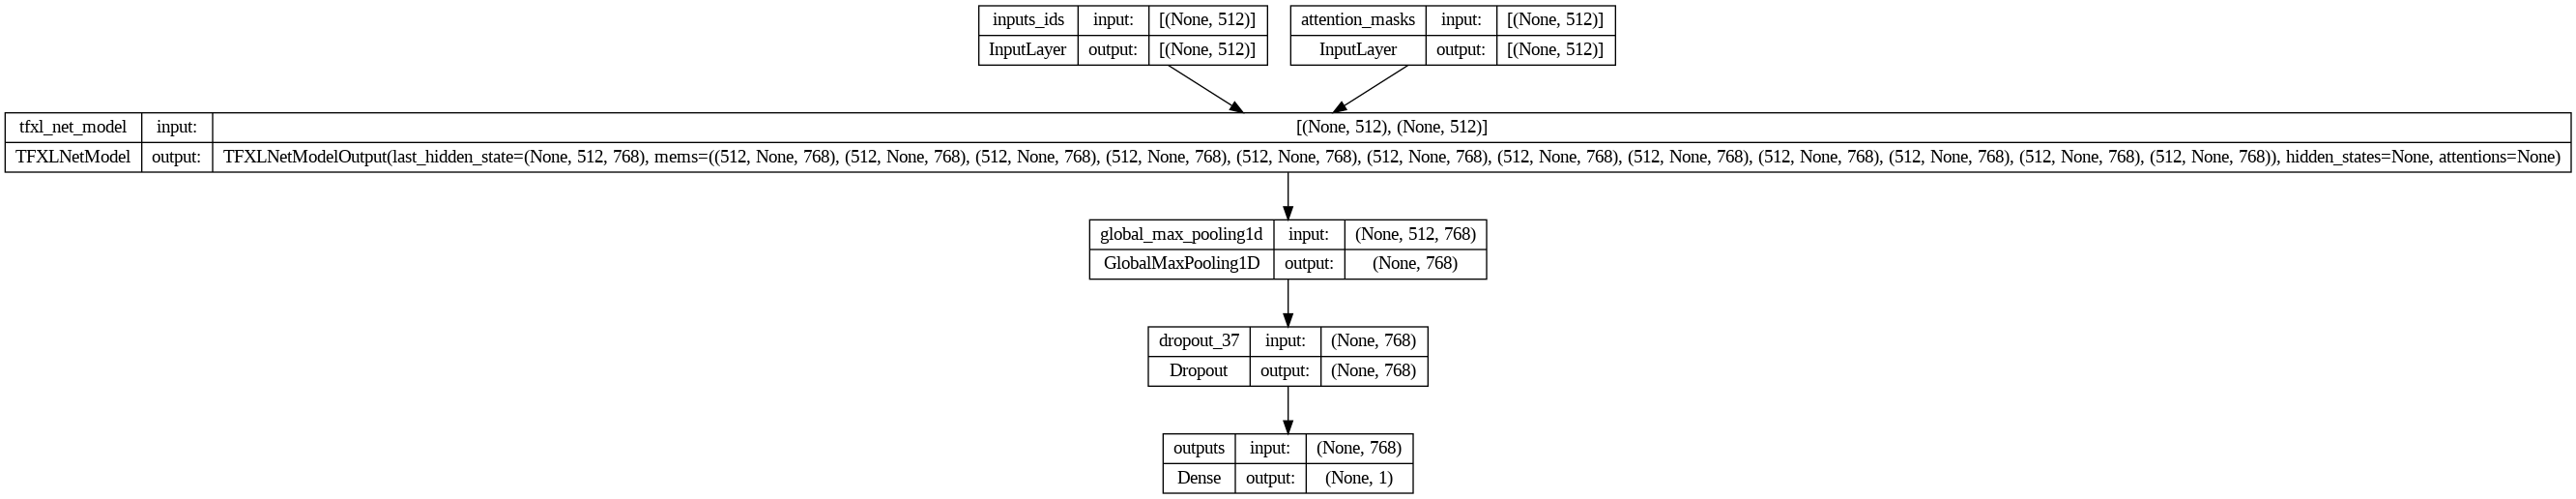

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(xlnet, to_file='model_xl.png', expand_nested=True, show_shapes=True)

In [12]:
def tokenize_corpus(data, tokenizer, max_len):
  input_ids = []
  attention_masks = []
  for sample in data:
    tokenized_sample = tokenizer(sample, padding='max_length', max_length=512, truncation=True)
    input_ids.append(tokenized_sample['input_ids'])
    attention_masks.append(tokenized_sample['attention_mask'])
  return input_ids, attention_masks

In [14]:
# create tokenized data
train_input_ids, train_attention_masks = tokenize_corpus(all_train_text, xlnet_tokenizer, 512)
dev_input_ids, dev_attention_masks = tokenize_corpus(all_dev_text, xlnet_tokenizer, 512)

In [21]:
history_xl = xlnet.fit([np.array(train_input_ids[:-1]), np.array(train_attention_masks[:-1])], np.array(all_train_labels[:-1]), validation_data=([np.array(dev_input_ids), np.array(dev_attention_masks)], np.array(all_dev_labels)), epochs=1,batch_size=4)

KeyboardInterrupt: ignored

In [23]:
print(history_xl.history['accuracy'])
print(history_xl.history['f1_score'])